In [1]:
import os
import math
import glob
import numpy
import rasterio as rio
import matplotlib.pyplot as plt
import geopandas
from descartes import PolygonPatch
import random
from shapely.geometry import Polygon, MultiPolygon
random.seed(10)

# Functions

In [8]:
def plot_sat(path,gdf=None, fill=False,linewidth=2):
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    
    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))
    
    if gdf is not None:
        ax = plot_gdf(gdf,fill=fill,ax=ax,linewidth=linewidth)
    ax.imshow(r)

In [7]:
def plot_gdf(gdf,fill=False,ax=None,linewidth=2, kw='geometry'):
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
        
    for geom in gdf[kw]:
        try:
            if fill:
                patch = PolygonPatch(geom,linewidth=linewidth,color='fuchsia')
                ax.add_patch(patch)
            else:
                ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            # TODO fix bc missing data
            pass
    return(ax)

In [11]:
def plot_gdf_circle(gdf_, circs, fill=False,ax=None,linewidth=2, multicircs=True, kw='geometry'):
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
    
    for geom in gdf_[kw]:
        try:
            if fill:
                patch = PolygonPatch(geom,linewidth=linewidth,color='fuchsia')
                ax.add_patch(patch)
            else:
                ax.plot(*geom.exterior.xy,linewidth=linewidth)
        except AttributeError:
            pass
    if multicircs:
        for circ_ in circs:
            ax.plot(*circ_.exterior.xy, linewidth=linewidth)
            ax.axis('tight')
    else: ax.plot(*circs.exterior.xy, linewidth=linewidth)
    
    return ax

In [9]:
def create_meshgrid(gdf_, step=10, kw='px_geometry', plot=True):
    
    xmax = max(max([(poly.bounds[0], poly.bounds[2]) for poly in gdf_[kw]]))
    ymax = max(max([(poly.bounds[1], poly.bounds[3]) for poly in gdf_[kw]]))

    # if left > bottom and right > top:
    #     xx, yy = numpy.meshgrid(numpy.arange(bottom, left, step), 
    #                         numpy.arange(top, right, step))
    # elif left > bottom:
    #     xx, yy = numpy.meshgrid(numpy.arange(bottom, left, step), 
    #                         numpy.arange(right, top, step))
    # elif right > top:
    #     xx, yy = numpy.meshgrid(numpy.arange(left,  bottom, step), 
    #                             numpy.arange(top, right,    step))
    # else: 

    xx, yy = numpy.meshgrid(numpy.arange(0, xmax, step), 
                        numpy.arange(0, ymax, step))

    x = [z for x in xx for z in x]
    y = [z for x in yy for z in x]
    if plot:
        plt.plot(xx.flat, yy.flat, ".")
        plt.show()

    return list(zip(x, y))

In [10]:
# This function gets just one pair of coordinates based on the angle theta
def get_circle_coord(theta, x_center, y_center, radius):
    x = radius * math.cos(theta) + x_center
    y = radius * math.sin(theta) + y_center
    return (x,y)

# This function gets all the pairs of coordinates
def get_all_circle_coords(x_center, y_center, radius, n_points):
    thetas = [i/n_points * math.tau for i in range(n_points)]
    circle_coords = [get_circle_coord(theta, x_center, y_center, radius) for theta in thetas]
    return circle_coords

def circle_coords_fn(x_center, y_center, radius, n_points, offset=(20,20)):
    """
    Compute circle coordinates using a center point (x, y)
    and radius. The number of coordinates computed is n_points.
    """
    thetas = [i/n_points * math.tau for i in range(n_points)]
    xoff, yoff = offset
    return [(radius*math.cos(theta)+(x_center-xoff), radius*math.sin(theta)+(y_center-yoff)) for theta in thetas]

# Using the second function to generate all the pairs of coordinates.
# circle_coords = circle_coords_fn(x_center = 595134, 
#                                       y_center = 5751614,
#                                       radius = 30,
#                                       n_points = 100)

In [13]:
def pixel_translate(polygon, gdf_, adjust=(900, 900)):

    xmin = min(min([(poly.bounds[0], poly.bounds[2]) for poly in gdf_['geometry']]))
    ymin = min(min([(poly.bounds[1], poly.bounds[3]) for poly in gdf_['geometry']]))
    
    new_poly = []
    if polygon.geom_type == "Polygon":
        coords = list(polygon.exterior.coords)
        for coord in coords:
            cx, cy, cz = coord
            assert cz == 0.0
            if ymin == 0:
                newY = cy
            elif ymin < 0 or ymin > 0:
                newY = cy - ymin
            if xmin == 0:
                newX = cx
            elif xmin < 0 or xmin > 0:
                newX = cx - xmin
            newX = newX * adjust[0]
            newY = newY * adjust[1]
            new_poly.append((newX, newY, cz))
        return Polygon(new_poly)
    
    elif polygon.geom_type == "MultiPolygon":
        coords = [list(poly.exterior.coords) for poly in list(polygon.geoms)]
        for lst in coords:
            sublst = []
            for coord in lst:
                cx, cy, cz = coord
                assert cz == 0.0
                if ymin == 0:
                    newY = cy
                elif ymin < 0 or ymin > 0:
                    newY = cy - ymin
                if xmin == 0:
                    newX = cx
                elif xmin < 0 or xmin > 0:
                    newX = cx - xmin
                newX = newX * adjust[0]
                newY = newY * adjust[1]
                sublst.append((newX, newY, cz))
            new_poly.append(sublst)
            
        return MultiPolygon([Polygon(p) for p in new_poly])

In [12]:
def pixel_scale(polygon, gdf_):

    max_ = max(max([(poly.bounds[0], poly.bounds[2]) for poly in gdf_['geometry']]))
    min_ = min(min([(poly.bounds[1], poly.bounds[3]) for poly in gdf_['geometry']]))

    scaledMax = 2**12
    scaledMin = 0 #-2**12
    
    new_poly = []
    if polygon.geom_type == "Polygon":
        coords = list(polygon.exterior.coords)
        for coord in coords:
            cx, cy, cz = coord
            assert cz == 0.0
            newY = ( ( (scaledMax - scaledMin) * (cy - min_) ) / (max_ - min_) ) + scaledMin
            newX = ( ( (scaledMax - scaledMin) * (cx - min_) ) / (max_ - min_) ) + scaledMin
            new_poly.append((newX, newY, cz))
        return Polygon(new_poly)
    
    elif polygon.geom_type == "MultiPolygon":
        coords = [list(poly.exterior.coords) for poly in list(polygon.geoms)]
        for lst in coords:
            sublst = []
            for coord in lst:
                cx, cy, cz = coord
                assert cz == 0.0
                newY = ( ( (scaledMax - scaledMin) * (cy - min_) ) / (max_ - min_) ) + scaledMin
                newX = ( ( (scaledMax - scaledMin) * (cx - min_) ) / (max_ - min_) ) + scaledMin
                sublst.append((newX, newY, cz))
            new_poly.append(sublst)
            
        return MultiPolygon([Polygon(p) for p in new_poly])

# Main

In [2]:
# change datapath here
data = "/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam"

In [3]:
geojsons = sorted(glob.glob(f"{os.path.join(data, 'geojson_buildings')}/*.geojson"), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))

In [4]:
tifs = sorted(glob.glob(f"{os.path.join(data, 'PS-RGBNIR')}/*.tif"), key=lambda s: int(s.split("_tile_")[1].split('.')[0]))

In [5]:
for tif in tifs:
    input_file = tif
    fname = os.path.basename(input_file)
    save_dir = os.path.split(os.path.dirname(input_file))[0]
    if not os.path.exists(f'{save_dir}/processed/PS-RGBNIR'):
        os.makedirs(f'{save_dir}/processed/PS-RGBNIR')
    output_file = f'{save_dir}/processed/PS-RGBNIR/{fname}'
    if os.path.exists(output_file):
        print(f'{output_file} already exists')
        continue
    with rio.open(input_file) as src:
        data = src.read()
        rotated_data = numpy.rot90(data, k=1, axes=(1, 2))
        transform = src.transform * src.transform.rotation(-90)
        with rio.open(
                output_file,
                'w',
                driver=src.driver,
                height=rotated_data.shape[2],
                width=rotated_data.shape[1],
                count=src.count,
                dtype=rotated_data.dtype,
                crs=src.crs,
                transform=transform
        ) as dst:
            dst.write(rotated_data)

/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam/processed/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804120223_20190804120456_tile_55.tif already exists
/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam/processed/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190804120223_20190804120456_tile_69.tif already exists
/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam/processed/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190822091156_20190822091502_tile_108.tif already exists
/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam/processed/PS-RGBNIR/SN6_Train_AOI_11_Rotterdam_PS-RGBNIR_20190823082625_20190823082938_tile_442.tif already exists
/Users/nish/Workspaces/Satellite_Fusion/data/SN6_buildings_AOI_11_Rotterdam_train_sample/AOI_11_Rotterdam/processed/PS

In [6]:
# this is used to generate pin counts
datas = list(zip(tifs, geojsons))

/var/folders/rz/26nbj19s1_33yvwj408l10gr0000gn/T/ipykernel_16408/1178491834.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgdf['px_geometry'][coords[0]] = Polygon(list(zip(coords[1][0], coords[1][1])))
/var/folders/rz/26nbj19s1_33yvwj408l10gr0000gn/T/ipykernel_16408/1178491834.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testgdf['px_geometry'][coords[0]] = MultiPolygon(polys)
/var/folders/rz/26nbj19s1_33yvwj408l10gr0000gn/T/ipykernel_16408/1178491834.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

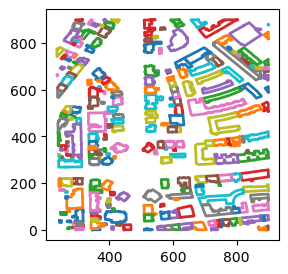

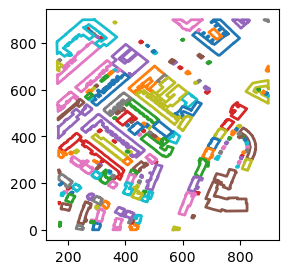

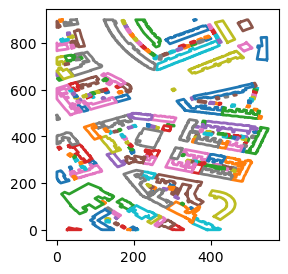

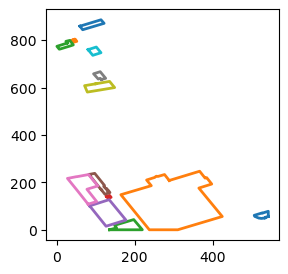

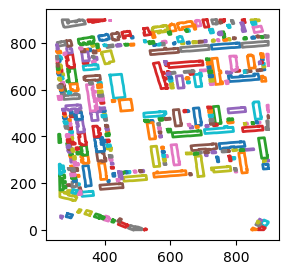

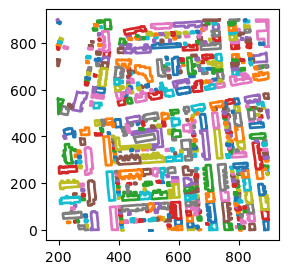

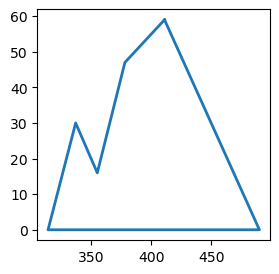

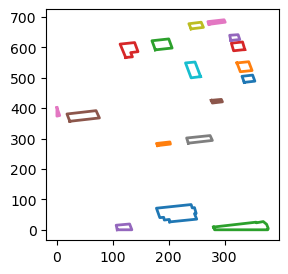

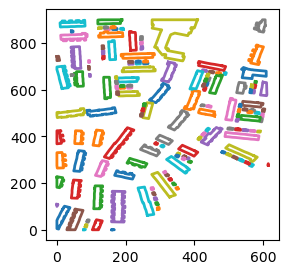

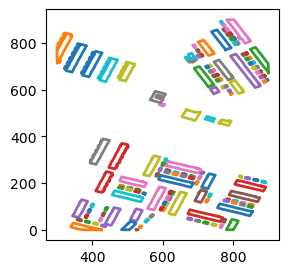

In [14]:
for i, _ in enumerate(datas):    
    filename = datas[i][0]
    gdf = geopandas.read_file(datas[i][1])
    testgdf = gdf.copy()
    src = rio.open(filename)
    testgdf['px_geometry'] = testgdf['geometry'].apply(lambda x: rio.transform.rowcol(src.transform, [i[0] for i in x.exterior.coords], [i[1] for i in x.exterior.coords]) \
        if x.geom_type == 'Polygon' else [rio.transform.rowcol(src.transform, [i[0] for i in poly.exterior.coords], [i[1] for i in poly.exterior.coords]) for poly in list(x.geoms)])
    for coords in enumerate(testgdf['px_geometry']):
        try:
            testgdf['px_geometry'][coords[0]] = Polygon(list(zip(coords[1][0], coords[1][1])))
        except TypeError:
            polys = []
            for poly in coords[1]:
                polys.append(Polygon(list(zip(poly[0], poly[1]))))
            testgdf['px_geometry'][coords[0]] = MultiPolygon(polys)
    plot_gdf(testgdf, linewidth=2, kw='px_geometry')

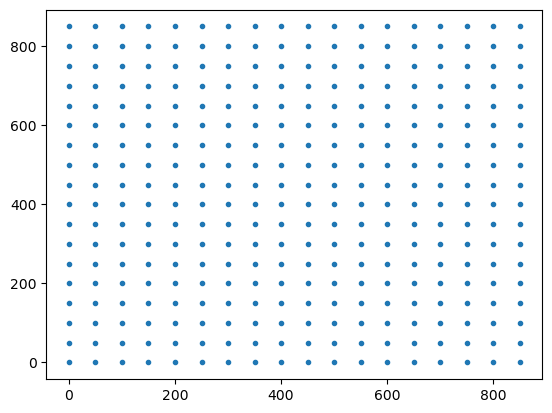

In [17]:
circle_coords = create_meshgrid(testgdf, step=50)
circ = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], 1, 100, offset=(0,0))) for circ_coors in circle_coords]

<Axes: >

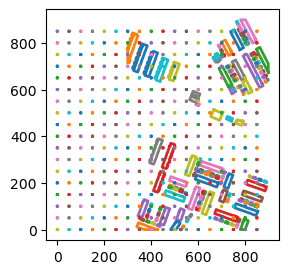

In [18]:
plot_gdf_circle(testgdf, circ, multicircs=True, kw='px_geometry')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

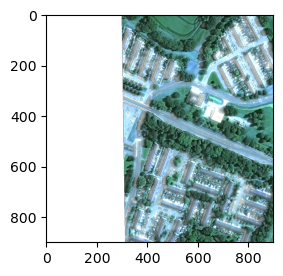

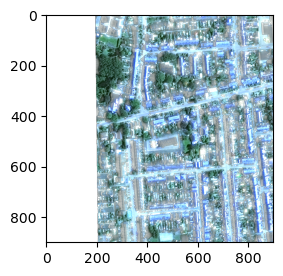

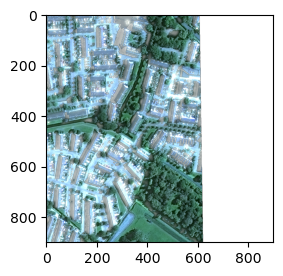

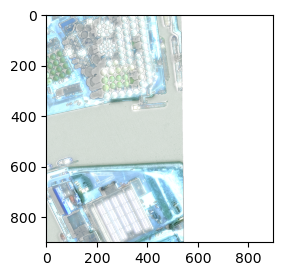

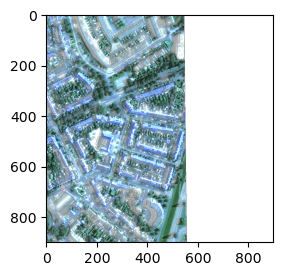

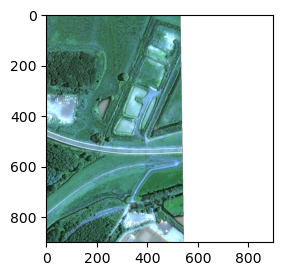

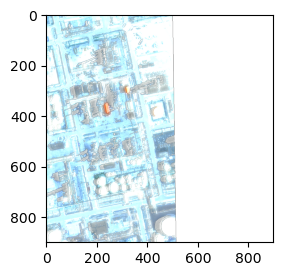

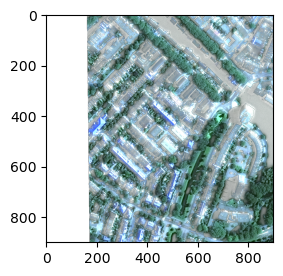

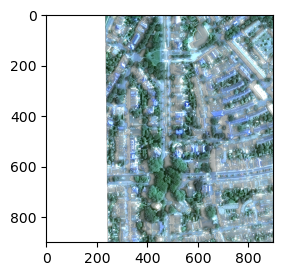

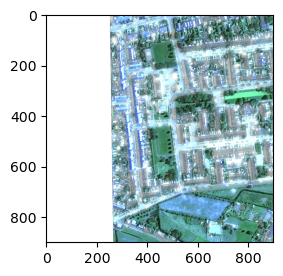

In [47]:
procs = glob.glob(f'{os.path.join(save_dir, "processed", "PS-RGBNIR")}/*.tif')
for i, _ in enumerate(procs):
    src = rio.open(procs[i])
    plot_sat(procs[i], gdf=testgdf, linewidth=2)

# Scaling and Translation Tests

In [33]:
testgdf['geometry'] = testgdf['geometry'].apply(lambda x: pixel_scale(x, testgdf))

<Axes: >

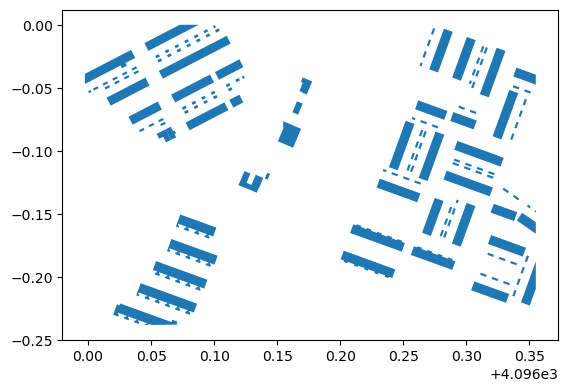

In [34]:
# ensure scaling
testgdf['geometry'].plot()

In [35]:
testgdf['geometry'] = testgdf['geometry'].apply(lambda x: pixel_translate(x, testgdf))

<Axes: >

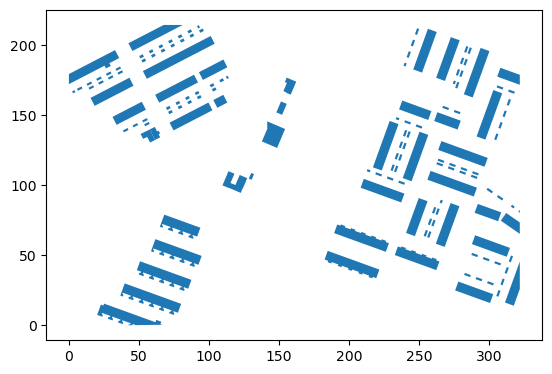

In [36]:
# ensure translation
testgdf['geometry'].plot()

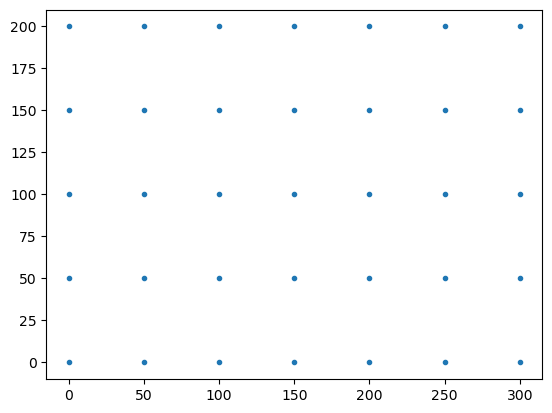

In [37]:
circle_coords = create_meshgrid(testgdf, step=50)
circ = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], 1, 100, offset=(0,0))) for circ_coors in circle_coords]

<Axes: >

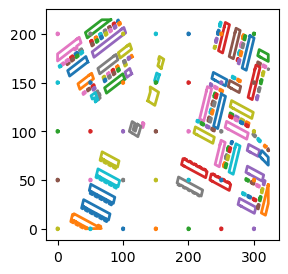

In [38]:
plot_gdf_circle(testgdf, circ, multicircs=True)

In [307]:
# main generator
def generate_pin_counts(data_list, rad=20, step=100, stop=6, crs='epsg:32631', off=(20, 20)):
    """
    Generate random pins (x, y) and count of buildings 
    in a given list of geojsons
    """
    out = []
    N = 0
    for rastr, geojs in data_list:
        gdf_ = geopandas.read_file(geojs)
        gdf_['geometry'] = gdf_['geometry'].apply(lambda x: pixel_scale(x, gdf_))
        gdf_['geometry'] = gdf_['geometry'].apply(lambda x: pixel_translate(x, gdf_))
        
        grid = create_meshgrid(gdf_, step=step, plot=False)
        circs = [Polygon(circle_coords_fn(circ_coors[0], circ_coors[1], rad, 100, offset=off)) for circ_coors in grid]
        cg = list(zip(circs, grid))
        plot_gdf_circle(gdf_, circs, multicircs=True)

        lst = [((g[0], g[1]), len(geopandas.sjoin(geopandas.GeoDataFrame(index=[0], crs=crs, geometry=[c]), gdf_))) for c,g in cg]
        xs = np.array([loc[0][0] for loc in lst])
        ys = np.array([loc[0][1] for loc in lst])
        with rio.open(rastr) as src:
            rows, cols = rio.transform.rowcol(src.transform, xs, ys)
            xy = list(zip(rows, cols))
        out.append([rastr, [loc for loc, _ in lst], [cnt for _, cnt in lst]])
        N += 1
        if N >= stop:
            break
    return out

In [308]:
import time

27.466696977615356


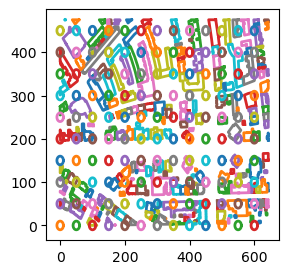

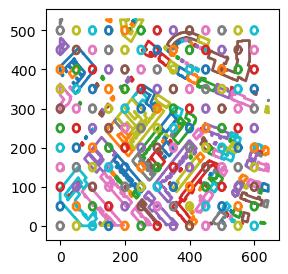

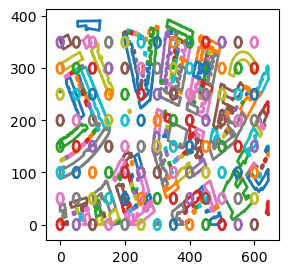

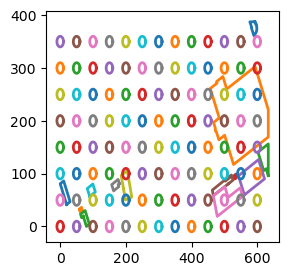

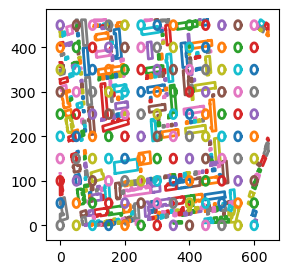

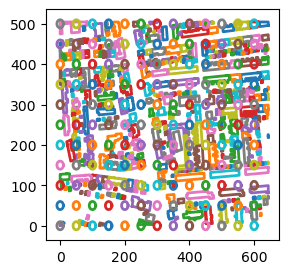

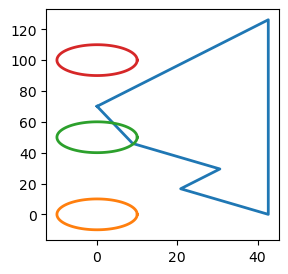

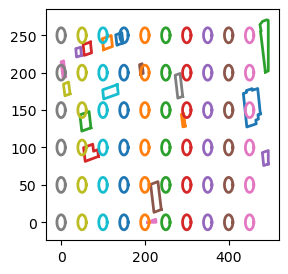

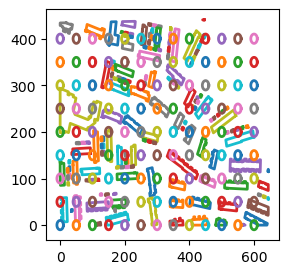

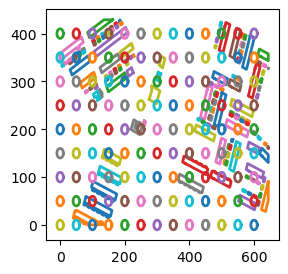

In [309]:
start_time = time.time()
out = generate_pin_counts(datas, rad=10, step=50, stop=len(datas), off=(0, 0))
elapsed_time = time.time() - start_time
print(elapsed_time)

In [24]:
# max buildings intersected by a pin in each output array
[max(out[i][2]) for i in range(len(out))]

[6, 6, 10, 3, 7, 8, 1, 1, 5, 5]

In [25]:
# non-zero array indices for each output array
# confirms that pins are intersecting buildings
[np.nonzero(out[i][2]) for i in range(len(out))]

[(array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 23, 24, 25,
         26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
         43, 44, 45, 46, 47]),),
 (array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19,
         20, 21, 22, 23, 26, 27, 28, 29, 32, 34, 35, 37, 38, 39, 40, 41, 43,
         44, 45, 46]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37]),),
 (array([ 1,  8,  9, 10, 14, 15, 22, 23, 30, 31]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
         19, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43,
         44, 45, 47]),),
 (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),),
 (array([1]),),
 (array([ 7, 12, 

In [26]:
import pandas as pd
pd.DataFrame(out).to_csv('building_test.csv')

In [28]:
[out[i][3] for i in range(len(out))]

[(365.89964275434613, 270.2472859765403),
 (366.1232228213921, 299.85732117993757),
 (365.82444165088236, 223.20448335958645),
 (360.465986575, 220.46333671407774),
 (366.22362072300166, 262.85207841778174),
 (366.2145971516147, 287.01840456714854),
 (24.265733879059553, 71.77101761149243),
 (281.39051338564605, 144.2766819964163),
 (366.38440005108714, 250.67583947535604),
 (366.36095864279196, 243.8259127466008)]